In [1]:
!pip install -q transformers 

Here we import everything required for preprocessing, training and evaluation 

In [2]:
import torch
from transformers import get_linear_schedule_with_warmup
import transformers
import pandas as pd
import numpy as np 
import torch.nn as nn
from tqdm import tqdm 
from sklearn import model_selection,metrics
import re

**Preprocessing**\
Stripping extra whitespaces around the text.
Replacing escape characters with whitespace.
Padding all punctuations with whitespaces on both sides.

In [ ]:
def preprocessing(dataframe):  
  def clean_abstract(text):
    text = text.split()
    text = [x.strip() for x in text]
    text = [x.replace('\n',' ').replace("\t"," ") for x in text]
    text = " ".join(text)
    text = re.sub("([.,?()])",r"\1",text)
    return text
  
  def get_texts(dataframe):
    dataframe["ABSTRACT"] = dataframe["ABSTRACT"].apply(clean_abstract)
    return dataframe.iloc[:,1:3]

  def get_labels(dataframe):
    label_df = dataframe.iloc[:,3:]
    return label_df
  return get_texts(dataframe),get_labels(dataframe)

**Dataset preparation** \
Getting text and tokenizing with scientific-bert tokenizer from bert based models of Hugging-face transformers. Tokenizer returns input ids and attention masks, this helpful for supplying directly to its model.

In [ ]:

class BERTDataset(torch.utils.data.Dataset):
  def __init__(self,title,abstract,targets,tokenizer,max_len):
    super(BERTDataset,self).__init__()
    self.title = title
    self.abstract = abstract
    self.targets = targets
    self.tokenize = tokenizer
    self.max_len = max_len
 
  def __len__(self):
    return len(self.title)
  
  def __getitem__(self,item):
    title = str(self.title[item])
    abstract = str(self.abstract[item])
    #merging title and abstract as one text 
    input = self.tokenize.encode_plus(
        title +' '+ abstract,
        None,
        truncation = True,
        return_token_type_ids = False,
        max_length = self.max_len,
        padding='max_length',
    )
    ids = input['input_ids']
    mask = input['attention_mask'] 
    return {
        'ids':torch.tensor(ids, dtype = torch.long),
        'mask': torch.tensor(mask,dtype = torch.long),
        'targets': torch.tensor(self.targets[item,:], dtype = torch.float)
    }

**Model** \
Here we use transformer model and fully connected linear layer to get the required number of ouput labels. As usual transformer model outputs 768.  

In [ ]:
class BERTBaseUncased(nn.Module):
    def __init__(self,bert_pretrained_weights):
      super(BERTBaseUncased,self).__init__()
      bert_model = bert_pretrained_weights
      self.bert = transformers.AutoModel.from_pretrained(bert_model)
      self.bert_drop = nn.Dropout(0.3)
      self.fc = nn.Linear(768,NUM_LABELS)
    
    def forward(self,ids,masks):
      _,o2 = self.bert(
          input_ids = ids,
          attention_mask = masks,
          #token_type_ids = token_type_ids        
          ) 
      o = self.bert_drop(o2)
      return self.fc(o)

**Loss Function**
BCEWithLogitsLoss is most choosen for use, because it comes with sigmoid layer included with bce logloss, and greater stability. \
*BCEWithLogitsLoss = Sigmoid Layer + BCELoss*

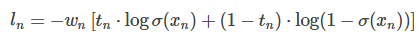

Good thing about BCEWithLogitsloss is its weight components in the equation. 

In [4]:
def loss_fn(output,targets):
  return nn.BCEWithLogitsLoss()(output,targets)

**Training function and Evaluation function** \

In [ ]:

def train_fn(data_loader,model,device,optimizer,scheduler=None):
  model.train()
  avg_loss=0
  for b,d in tqdm(enumerate(data_loader),total = len(data_loader)):
    ids = d['ids']
    mask = d['mask']
    targets = d['targets']
    ids = ids.to(device, dtype = torch.long)
    mask = mask.to(device, dtype = torch.long)
    targets = targets.to(device, dtype = torch.float)
    optimizer.zero_grad()
    output = model(ids = ids,
                   masks = mask,
                   )
    loss = loss_fn(output,targets)
    loss.backward()
    avg_loss+=loss
    optimizer.step()
    if scheduler is not None:
      scheduler.step()
    
  return avg_loss/len(data_loader) 
 
 
 
def eval_fn(data_loader,model,device):
  model.eval()
  fin_output = []
  fin_target = []
  fin_loss = 0
  with torch.no_grad():
    for b,d in tqdm(enumerate(data_loader),total = len(data_loader)):
        ids = d['ids']
        mask = d['mask']
        targets = d['targets']
        ids = ids.to(device, dtype = torch.long)
        mask = mask.to(device, dtype = torch.long)
        targets = targets.to(device, dtype = torch.float)
        output = model(ids = ids,
                      masks = mask,
                      )
        loss = loss_fn(output,targets)
        logits = torch.sigmoid(output)
        output = np.round(logits.cpu().detach().numpy())
        fin_output.extend(output)
        fin_target.extend(targets.cpu().detach().numpy())
        fin_loss+=loss
  return loss/len(data_loader),fin_output,fin_target

**Training the model** \


In [6]:

def run():
  dfx = pd.read_csv('/content/train.csv').fillna("none")
  sample = pd.read_csv("sample_submission.csv")
  test_cols = list(sample.drop(columns = "ID").columns)
  df_train,df_valid = model_selection.train_test_split(dfx,
                                                       test_size = 0.25,
                                                       random_state = 42)
  df_train = df_train.reset_index(drop=True)
  df_valid = df_valid.reset_index(drop=True)
  train_targets = df_train[test_cols].values
  valid_targets = df_valid[test_cols].values
  train_dataset = BERTDataset(title=df_train.TITLE.values,
                              abstract = df_train.ABSTRACT.values,
                              targets = train_targets,
                              tokenizer = TOKENIZER,
                              max_len = MAX_LEN)
  
  train_dataloader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size = TRAIN_BATCH_SIZE,
      shuffle = True,
      num_workers = 0
      )
  valid_dataset = BERTDataset(title=df_valid.TITLE.values,
                              abstract = df_valid.ABSTRACT.values,
                              targets = valid_targets,
                              tokenizer = TOKENIZER,
                              max_len = MAX_LEN)
  valid_dataloader = torch.utils.data.DataLoader(
      valid_dataset,
      batch_size = VALID_BATCH_SIZE,
      shuffle = False,
      num_workers = 0
      ) 
  model = BERTBaseUncased(MODAL_PATH).to(device)
  param_optimizer = list(model.named_parameters())
  no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
  optimizer_parameters = [
      {
          "params": [
              p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.001,
      },
      {
          "params": [
              p for n, p in param_optimizer if any(nd in n for nd in no_decay)
          ],
          "weight_decay": 0.01,
      },
  ]
  optimizer = transformers.AdamW(optimizer_parameters, lr=LR)
  num_training_steps = len(train_dataloader) * EPOCHS
  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=num_training_steps
  )

  max_f1_score = 0
  for epoch in range(EPOCHS):
    train_fn(
        data_loader = train_dataloader,
        model = model,
        device = device,
        optimizer = optimizer)
    loss, output, target = eval_fn(
        data_loader = valid_dataloader,
        model =model,
        device = device)
    f1_score = metrics.f1_score(target,output,average = 'micro')
    if f1_score > max_f1_score:
      torch.save(model.state_dict(),'model.bin')
      print(f"model Saved {f1_score}")
      max_f1_score = f1_score
    print(f"EPOCH: {epoch+1}, microF1_SCORE : {f1_score}")
  return f1_score 

CONFIGURATION DATA FOR TRAINING

In [7]:
MAX_LEN = 320
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 8
VALIDATION_SPLIT = 0.25
MODAL_PATH  = "allenai/scibert_scivocab_uncased"
TOKENIZER = transformers.AutoTokenizer.from_pretrained(MODAL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LR = 3e-5
EPOCHS = 5
SEED = 32
NUM_LABELS = 6

#Training starts here
run() 

  0%|          | 0/984 [00:00<?, ?it/s]

model Saved 0.8349499495615738
EPOCH: 1, microF1_SCORE : 0.8349499495615738


  0%|          | 0/984 [00:00<?, ?it/s]

model Saved 0.8425339366515836
EPOCH: 2, microF1_SCORE : 0.8425339366515836


  0%|          | 0/984 [00:00<?, ?it/s]

EPOCH: 3, microF1_SCORE : 0.8337389717067235


  0%|          | 0/984 [00:00<?, ?it/s]

EPOCH: 4, microF1_SCORE : 0.8386813186813187


100%|██████████| 656/656 [03:48<00:00,  2.87it/s]


EPOCH: 5, microF1_SCORE : 0.8340515612005746


0.8340515612005746